# Tutorial 1 - Getting Started

In this first tutorial notebook we will be creating a simple KAN model and train it to perform function fitting.

In [1]:
import os
import sys

# Workaround to import jaxKAN
project_root = os.path.abspath("..")
sys.path.append(project_root)

from jaxkan.KAN import KAN

import jax
import jax.numpy as jnp

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from flax import nnx
import optax

import matplotlib.pyplot as plt
import numpy as np

## Data Generation

We begin with the generation of some mock data. Consider the function $f(x, y) = x^2 + 2\exp(y)$. We will attempt to fit a KAN model on synthetic data generated from this function and then evaluate its performance.

In [2]:
def f(x,y):
    return x**2 + 2*jnp.exp(y)

def generate_data(minval=-1, maxval=1, num_samples=1000, seed=42):
    key = jax.random.PRNGKey(seed)
    x_key, y_key = jax.random.split(key)

    x1 = jax.random.uniform(x_key, shape=(num_samples,), minval=minval, maxval=maxval)
    x2 = jax.random.uniform(y_key, shape=(num_samples,), minval=minval, maxval=maxval)

    y = f(x1, x2).reshape(-1, 1)
    X = jnp.stack([x1, x2], axis=1)
    
    return X, y

In [3]:
seed = 42

X, y = generate_data(minval=-1, maxval=1, num_samples=1000, seed=seed)

## Preprocessing

With the data at hand, we may perform the usual train/test splitting.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (800, 2)
Test set size: (200, 2)


Note that the shapes of the objects are `(batch, input_dim)`.

## KAN Model

Selecting and initializing a jaxKAN model is straightforward. One needs to define the following arguments, which are universal for all KAN Layer types:

- `layer_dims`: The dimensions for each of the network's layers' input/output nodes.
- `layer_type`: The type of KAN layer to use, which defaults to `spline`.
- `add_bias`: A boolean that controls whether bias terms are added to the network.
- `rngs`: A `nnx.Rngs` type object that essentially corresponds to a seed for weight initialization.

Apart from these, there is also the `required_parameters` argument, which is simply a dictionary with keys that correspond to additional parameters of the specific chosen layer. For example, a Chebychev layer has only one such parameter: `k`, the degree of the Chebychev polynomials.

We will use a Chebychev-based KAN for the present example.

In [5]:
# Initialize a KAN model
n_in = X_train.shape[1]
n_out = y_train.shape[1]
n_hidden = 6

layer_dims = [n_in, n_hidden, n_hidden, n_out]
req_params = {'k': 5}

model = KAN(layer_dims = layer_dims,
            layer_type = 'cheby',
            required_parameters = req_params,
            add_bias = True,
            rngs = nnx.Rngs(seed)
           )

print(model)

KAN(
  add_bias=True,
  layer_type='cheby',
  layers=[ChebyLayer(
    n_in=2,
    n_out=6,
    k=5,
    c_basis=Param(
      value=Array(shape=(6, 2, 6), dtype=float32)
    ),
    c_act=Param(
      value=Array(shape=(6, 2), dtype=float32)
    )
  ), ChebyLayer(
    n_in=6,
    n_out=6,
    k=5,
    c_basis=Param(
      value=Array(shape=(6, 6, 6), dtype=float32)
    ),
    c_act=Param(
      value=Array(shape=(6, 6), dtype=float32)
    )
  ), ChebyLayer(
    n_in=6,
    n_out=1,
    k=5,
    c_basis=Param(
      value=Array(shape=(1, 6, 6), dtype=float32)
    ),
    c_act=Param(
      value=Array(shape=(1, 6), dtype=float32)
    )
  )],
  biases=[Param(
    value=Array(shape=(6,), dtype=float32)
  ), Param(
    value=Array(shape=(6,), dtype=float32)
  ), Param(
    value=Array([0.], dtype=float32)
  )]
)


## Training

To train the model on the data, we must first define an optimizer using the `optax` framework. For this example, we will define a simple Adam optimizer and wrap the optax optimizer and the model in a `nnx.Optimizer` object.

In [6]:
opt_type = optax.adam(learning_rate=0.001)

optimizer = nnx.Optimizer(model, opt_type)

We will then define the training step and decorate it with `@nnx.jit` to make it faster. The loss function will be a simple MSE Loss.

In [7]:
# Define train loop
@nnx.jit
def train_step(model, optimizer, X_train, y_train):

    def loss_fn(model):
        residual = model(X_train) - y_train
        loss = jnp.mean((residual)**2)

        return loss
    
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)
    
    return loss

At this point we may begin training the model and keep some logs, e.g., the training loss per epoch.

In [8]:
# Initialize train_losses
num_epochs = 2000
train_losses = jnp.zeros((num_epochs,))

for epoch in range(num_epochs):
    # Calculate the loss
    loss = train_step(model, optimizer, X_train, y_train)
    
    # Append the loss
    train_losses = train_losses.at[epoch].set(loss)

## Evaluation

First, we may plot the training losses to see if the model is indeed trained, i.e. backpropagation works as it should.

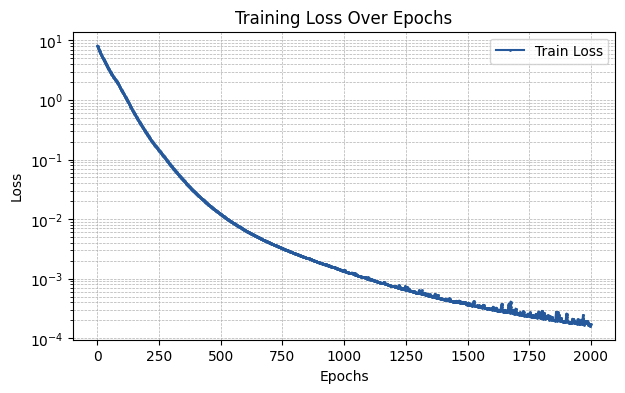

In [9]:
plt.figure(figsize=(7, 4))

plt.plot(np.array(train_losses), label='Train Loss', marker='o', color='#25599c', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.yscale('log')

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

plt.show()

Indeed, the model is trained as it should. The final step is to evaluate its performance on the test set.

In [10]:
y_pred = model(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"The MSE of the fit is {mse:.5f}")

The MSE of the fit is 0.00036


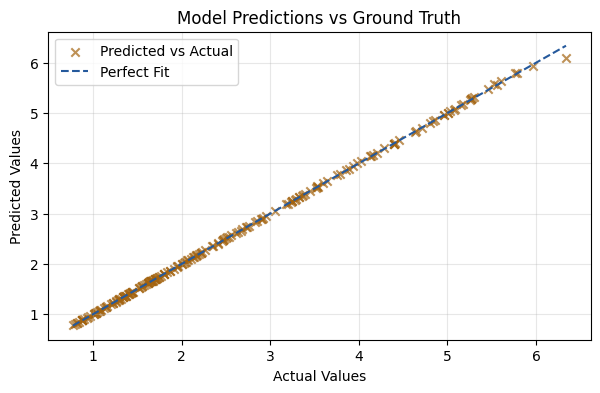

In [11]:
plt.figure(figsize=(7, 4))
plt.scatter(y_test, y_pred, alpha=0.7, color='#a3630f', marker='x', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='#25599c', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Model Predictions vs Ground Truth')
plt.legend()
plt.grid(alpha=0.3)
plt.show()